# Machine Learning pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  


## History
* Feb2022: Adding initial models with small dataset   
* March2022: Improved datasets representation
* April2022: Adds dataloader for clips and videos
* May2022: Tidies VGG2D and VGG3D   
* June2022: Tidies basicVGG model and adds heuristics for hyperarameters 
* Week1, July2022: Integreate modules in source path
* Week2, July2022: Implements Tromp2022Net DOI: https://doi.org/10.1016/S2589-7500(21)00235-17
* Week3, July2022: Adds LeNet, AlexNet and VGGNets, MobileNetV1, MobileNetV2
* Week4, July2022: Adds ShuffleNetV1, ShuffleNetV2, SqueezeNet_sources 0,1,2 and merge all to main!
* Week1, August2022: Adds EfficientNet_source0
* Week4, August2022: Adds ShrapML_replication_v00


## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* https://nestedsoftware.com/2019/09/09/pytorch-image-recognition-with-convolutional-networks-4k17.159805.html 
* https://ai.stackexchange.com/questions/5769/in-a-cnn-does-each-new-filter-have-different-weights-for-each-input-channel-or
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 
* Kerdegari H. et al. 2021 https://github.com/vital-ultrasound/lung/tree/main/multiclass_tensorflow
* https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
* https://github.com/shanglianlm0525/PyTorch-Networks



# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import io # io.StringIO(str(optimizer)
import sys
import argparse
import yaml
from pathlib import Path
import json
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm
import shutil

import numpy as np
import math
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, precision_recall_fscore_support
from datetime import datetime


from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.helpers.various import concatenating_YAML_via_tags, \
                                    plot_dataset_classes, \
                                    split_train_validate_sets
from source.helpers.learning_pipeline import get_class_distribution, \
                                            plot_from_dict, \
                                            creating_pair_of_clips, \
                                            pair_clips_labels, \
                                            animate_clips
from source.helpers.learning_misc import train_loop, \
                                        test_loop

from source.models.architectures import basicVGG, TrompNetV1, \
        LeNet5_source00, LeNet5_source01, LeNet5_source02, \
        AlexNet_source00, AlexNet_source01, AlexNet_source02, AlexNet_source03, \
        MobileNetV1, MobileNetV2, \
        SqueezeNet_source0, SqueezeNet_source1, SqueezeNet_source2, \
        EfficientNet_source0, \
        ShrapML_replication_v00
        #ShuffleNetV1, ShuffleNetV2 (require 3 channels of input images)

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_REPO_MODEL_PATH = HOME_PATH +'/' + REPOSITORY_PATH + '/data/models'
CONFIG_FILES_PATH= REPOSITORY_PATH + '/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)
PATH_for_temporal_files = os.path.join(HOME_PATH, 'datasets/vital-us/echocardiography/temporal-files')

## Setting TRAINING_CURVES_PATH
#CURRENT_PATH=os.path.abspath(os.getcwd())
RESULTS_PATH='scripts/learning-pipeline/results'
TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)

## Setting FULL_PATH_FOR_YML_FILE
yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )
print(f'FULL_REPO_MODEL_PATH: {FULL_REPO_MODEL_PATH}' )
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )



PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files/users_paths_files/config_users_paths_files_username_mx19.yml
FULL_REPO_MODEL_PATH: /home/mx19/repositories/echocardiography/data/models
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results


## 2. Generate list text files for train and validate datasets

Edit config_users_paths_files_username_$USER.yml at '../config_files/users_paths_files/config_users_paths_files_username_template.yml' with the right paths and percentage of `ntraining`:  
```
#ECHODATASET_PATH = config['echodataset_path'] # Default
ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-GOOD'
TRAINING_SPLITTING = 0.8 #config['ntraining'] #Default
randomise_file_list: False
```

## 2. Setting hyper-parameters and loading datasets using pytorch dataloader

In [2]:
START_TIME_OF_THE_NOTEBOOK = time.time()
print(f'Starting time of the notebook {START_TIME_OF_THE_NOTEBOOK}')

##############################
##### Setting up device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #or "cuda:NN" can also be used e.g., "cuda:0"
print(f'Device: {DEVICE}')

TRAIN_VERSION='train00'
# TRAIN_VERSION='train01'
# TRAIN_VERSION='train02'

TRAINING_SPLITTING = 0.70 #config['ntraining'] #Default
TEST_FRACTION = 0.15
VAL_FRACTION = 1-TRAINING_SPLITTING-TEST_FRACTION
print(f'train_set_size  {TRAINING_SPLITTING}, test_set_size {TEST_FRACTION}, val_test_size {VAL_FRACTION}')
FLAG_RANDOMISE_DATA=True #config['randomise_file_list'] #Default

### Trump et al. 2022 
##"We trained the models on 55487 images from 1145 individual echocardiograms (appendix pp 2–3)." 
##Appendix pp 2–3.
##AC4: TRAINING: total videos 740 total frames 9615; T
##      TESTING: total videos:64 total frames 1218                


##############################
## Setting ECHODATASET_PATH; 
#ECHODATASET_PATH = config['echodataset_path'] # Default

ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 720,
    #"Test Dataset Size": 320,
    #"Validation Dataset Size": 280,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 1280,
    #"Test Dataset Size": 560,
    #"Validation Dataset Size": 440,

# ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-20-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 2240,
    #"Test Dataset Size": 960,
    #"Validation Dataset Size": 720,

# ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects'
# #     "BATCH_SIZE_OF_CLIPS": 20,
# #     "FRAMES_PER_CLIP": 1,
# #     "Train Dataset Size": 3620,
# #     "Test Dataset Size": 1540,
# #     "Validation Dataset Size": 880,

# ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-33-subjects'
#     #"BATCH_SIZE_OF_CLIPS": ?,
#     #"FRAMES_PER_CLIP": ?,
#     #"Train Dataset Size": ?,
#     #"Test Dataset Size": ?,
#     #"Validation Dataset Size": ?,
    
    
split_train_validate_sets(  
                        ECHODATASET_PATH, #config['echodataset_path']
                        config['data_list_output_path'], 
                        TRAINING_SPLITTING,
                        TEST_FRACTION,
                        FLAG_RANDOMISE_DATA
                        )

# PRETRANSFORM_IM_SIZE = [64, 64] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [128, 128] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [256, 256] #[650, 690] original pixel size for VenueGO
PRETRANSFORM_IM_SIZE = [512, 512] #[650, 690] original pixel size for VenueGO #tested with ShrapML_replication_v00
# PRETRANSFORM_IM_SIZE = config['pretransform_im_size'] ##DEFAULT

### >> CHANGE DENSE LAYER FEATURES IN VGG3D
### >> `self.fc0 = nn.Linear(in_features=4194304, out_features=500) #128x128`

##############################
##### Experiments for Basic HYPERPARAMETER Heuristics 

#### TESTS
NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1
# NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 2 
# NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 5; 
# NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 15; 
# NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; 
# NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 20; 
# NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 30; 
# NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 40; 
# NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 50; 
# NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 60; 


# BATCH_SIZE_OF_CLIPS = 1; 
# BATCH_SIZE_OF_CLIPS = 2;
# BATCH_SIZE_OF_CLIPS = 3;
# BATCH_SIZE_OF_CLIPS = 4; 
# BATCH_SIZE_OF_CLIPS = 5; 
# BATCH_SIZE_OF_CLIPS = 10; 
# BATCH_SIZE_OF_CLIPS = 20; 
BATCH_SIZE_OF_CLIPS = 25; 
# BATCH_SIZE_OF_CLIPS = 30; 
# BATCH_SIZE_OF_CLIPS = 40;
# BATCH_SIZE_OF_CLIPS = 50; 
# BATCH_SIZE_OF_CLIPS = 60; 


#LEARNING_RATE= 0.00005; 


#################  LEARNING_RATE 
### EXPERIMENT 01,02,03,04
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.0000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00000005; 

#################  BATCH_SIZE_OF_CLIPS with LEARNING_RATE= 0.000005 as it is the best peformance of prevous LRs 
### EXPERIMENT 04,06,07,08
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 2; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 5; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 15; LEARNING_RATE= 0.000005; 

#################  NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP with LEARNING_RATE= 0.000005 and BATCH_SIZE_OF_CLIPS=10
### EXPERIMENT 09,10,11,12
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 2; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 7; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 13; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 20; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 

##TOADD
### * NUMBER_OF_FRAMES_AND PARTICPANTS
### * OPTIMISERS 

# LEARNING_RATE =Trial and Error with diffent values  0.00005; 0.0005; 0.005 and 0.000001; 0.00001; 0.0001; 0.001  


MAX_EPOCHS = 100 #Alternatvely, make use of: config['max_epochs']
# MAX_EPOCHS = 250 #lternatvely, make use of: config['max_epochs']
# MAX_EPOCHS = 500 #Alternatvely, make use of: config['max_epochs']


##############################
##### Setting up animation
interval_between_frames_in_milliseconds=33.3 ## 1/30=0.033333
frame_per_seconds_for_animated_frames=30


#SUBJECT_ID = '073'
#print(SUBJECT_ID)

### CUDA out of memory 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10
#PRETRANSFORM_IM_SIZE = [128, 128] 
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.05 GiB free; 8.53 GiB reserved in total by PyTorch)
## REBOOT MACHINE
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.13 GiB free; 8.53 GiB reserved in total by PyTorch)



##############################
## Setting labels
label_id = ('BKGR', '4CV')



Starting time of the notebook 1661515382.8271332
Device: cuda
train_set_size  0.7, test_set_size 0.15, val_test_size 0.15000000000000005
---------------------------------------------
  FILENAMES_len=16
======= video_filenames: ('/01NVb-003-043/T1/01NVb-003-043-1 echo.mp4', '/01NVb-003-040/T1/01NVb-003-040-1 echo.mp4', '/01NVb-003-041/T2/01NVb-003-041-2 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-2 echo.mp4', '/01NVb-003-045/T2/01NVB-003-045-2 echo.mp4', '/01NVb-003-044/T1/01NVb-003-044-2 echo.mp4', '/01NVb-003-045/T3/01NVb-003-045-3 echo.mp4', '/01NVb-003-042/T1/01NVb-003-042-1 echo.mp4', '/01NVb-003-041/T1/01NVb-003-041-1 echo.mp4', '/01NVb-003-040/T2/01NVb-003-040-2 echo.mp4', '/01NVb-003-043/T3/01NVb-003-043-3 echo.mp4', '/01NVb-003-042/T3/01NVb-003-042-3 echo.mp4', '/01NVb-003-044/T3/01NVb-003-044-3 echo.mp4', '/01NVb-003-041/T3/01NVb-003-041-3 echo.mp4', '/01NVb-003-045/T1/01NVb-003-045-1 echo.mp4', '/01NVb-003-042/T2/01NVb-003-042-2 echo.mp4')
======= label_filenames: ('/01NVb-00

In [3]:
# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=PRETRANSFORM_IM_SIZE),
        transforms.ToTensor(),
    ])
else:
    pretransform = None
    
    #config['use_train_augmentation']#Default
    
    
# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


train_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=train_transform, #None,#transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

test_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_test'],
    participant_path_json_list=config['participant_path_json_list_test'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=test_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

val_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=val_transform,
    use_tmp_storage=config['use_tmp_storage']
    )



  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects//01NVb-003-043/T1/01NVb-003-043-1 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.97199599141347 nframes=15245 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects//01NVb-003-040/T1/01NVb-003-040-1 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.971632559729454 nframes=18702 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects//01NVb-003-041/T2/01NVb-003-041-2 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.97271017303212 nframes=11183 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects//01NVb-003-043/T1/01NVb-003-043-2 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.971971788739964 nframes=15435 
  
 

## 3. Plotting Class Distribution (creates temp clips and it takes few minutes)

[INFO] [EchoClassesDataset.__getitem__()] - computing clips and saving to temporary folder /home/mx19/datasets/vital-us/echocardiography/temporal-files/echovideodatafiles_FRAMESPERCLIP1_PIXELSIZE_512W512H


/home/mx19/anaconda3/envs/rt-ai-echo-VE/lib/python3.8/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /tmp/pip-req-build-pma2oi4d/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


class_distribution(train_dataset): {'BKGR': 22, '4CV': 22}
class_distribution(test_dataset): {'BKGR': 4, '4CV': 4}
class_distribution(val_dataset): {'BKGR': 7, '4CV': 7}
Number of frames for training datasets 44
Number of frames for testing datasets 8
Number of frames for Validation datasets 14


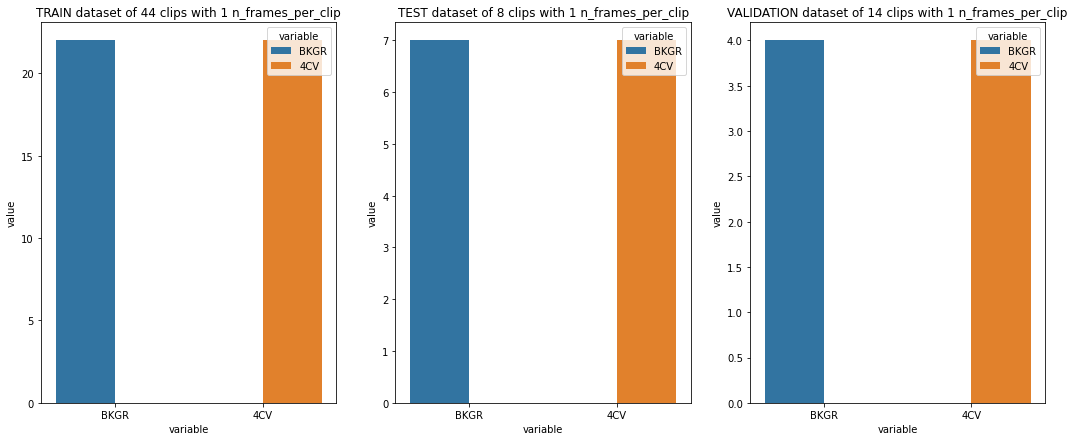

In [4]:
train_set_class_dict = get_class_distribution(train_dataset,label_id)
test_set_class_dict = get_class_distribution(test_dataset,label_id)
val_set_class_dict = get_class_distribution(val_dataset,label_id)


print(f'class_distribution(train_dataset): {train_set_class_dict}')
print(f'class_distribution(test_dataset): {test_set_class_dict}')
print(f'class_distribution(val_dataset): {val_set_class_dict}' )
    
#number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip']    
print(f'Number of frames for training datasets {len(train_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for testing datasets {len(test_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for Validation datasets {len(val_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')

plot_title_train_label= f'TRAIN dataset of {len(train_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(val_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(train_set_class_dict, plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(val_set_class_dict, plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(test_set_class_dict, plot_title=plot_title_val_label, ax=axes[2])
plt.show()



## 4. Animating frames of one clip of the dataloader

In [5]:
print(f'-----------------[val_dataset]-----------------')
clips=creating_pair_of_clips(val_dataset, label_id)
pair_clips_and_labels = pair_clips_labels(clips)

print(f'-----------------[test_dataset]-----------------')
clips=creating_pair_of_clips(test_dataset, label_id)
pair_clips_and_labels = pair_clips_labels(clips)

print(f'-----------------[train_dataset]-----------------')
clips=creating_pair_of_clips(train_dataset, label_id)
pair_clips_and_labels = pair_clips_labels(clips)


-----------------[val_dataset]-----------------
 CLIP:00 of BKGR label for torch.Size([1, 1, 512, 512]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 112
 CLIP:01 of BKGR label for torch.Size([1, 1, 512, 512]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 60
 CLIP:02 of BKGR label for torch.Size([1, 1, 512, 512]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 45
 CLIP:03 of BKGR label for torch.Size([1, 1, 512, 512]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 38
 CLIP:04 of BKGR label for torch.Size([1, 1, 512, 512]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 118
 CLIP:05 of BKGR label for torch.Size([1, 1, 512, 512]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 81
 CLIP:06 of BKGR label for torch.Size([1, 1, 512, 512]) TOTAL_FRAMES: 92 from clip_frame_clip_idx 69
 CLIP:07 of 4CV label for torch.Size([1, 1, 512, 512]) TOTAL_FRAMES: 102 from clip_frame_clip_idx 46
 CLIP:08 of 4CV label for torch.Size([1, 1, 512, 512]) TOTAL_FRAMES: 122 from clip_frame_clip_idx 56
 CLIP:09 of 4CV label for torch.Siz

<Figure size 432x288 with 0 Axes>

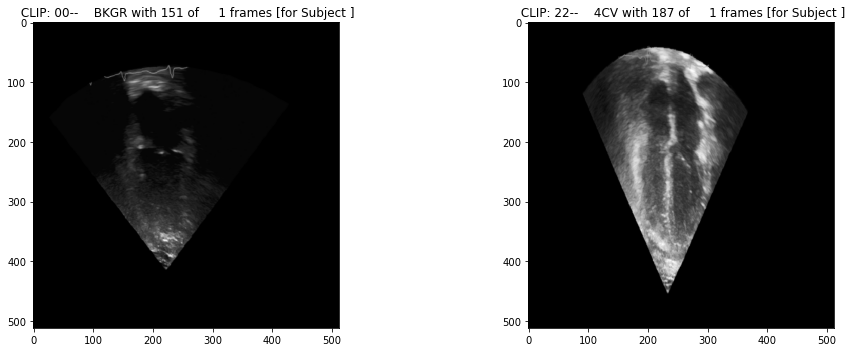

In [6]:
#average_HR =
#fps = 30
# 60 # beats per minute
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

PAIR_OF_CLIPS = pair_clips_and_labels[0]

animated_frames=animate_clips(PAIR_OF_CLIPS, label_id, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP,
                  interval_between_frames_in_milliseconds)
HTML(animated_frames.to_jshtml())      


# ##SAVE ANIMATIONS
# for idx in range(0,len(pair_clips_labels)):
#     PAIR_OF_CLIPS = pair_clips_labels[idx]
#     print( f' pair_clips_labels {str(PAIR_OF_CLIPS[2])} {str(PAIR_OF_CLIPS[6])}')
    

## 5. Displayting frames in the dataloader

In [7]:
print(f'====================================================')
print(f'train_dataset.__len__() = {train_dataset.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)


print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)} BATCHES of BATCH_SIZE_OF_CLIPS {BATCH_SIZE_OF_CLIPS}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} ')
        print(f'          label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'          Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'          Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()


print(f'====================================================')
print(f' test_dataset.__len__() = {test_dataset.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f' validation_dataset.__len__() = {val_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

train_dataset.__len__() = 44
len(train_dataloader): 2 BATCHES of BATCH_SIZE_OF_CLIPS 25
    BATCH_OF_CLIPS_INDEX : 0 / 1
    sample_batched_labels.size(): torch.Size([25])
    sample_batched_labels.squeeze().size(): torch.Size([25])
    sample_batched_images.size(): torch.Size([25, 1, 1, 512, 512])
        BATCH_SIZE_IDX 0 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 512, 512])
          Grid size torch.Size([3, 512, 512])
        BATCH_SIZE_IDX 1 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 512, 512])
          Grid size torch.Size([3, 512, 512])
        BATCH_SIZE_IDX 2 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 512, 512])
          Grid size torch.Size([3, 512, 512])
        BATCH_SIZE_IDX 3 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 512, 512])
          Grid size torch.Size([3, 512, 512])
        BATCH_SIZE_IDX 4 
          label: 1
   

## 7. Define networks
**This cell is useful to prototype other newtorks**
See `$HOMErepositories/echocardiography/source/models/arquitectures.py` to amend or implement other Neural Network Arquitectures!



## 8. Sanity checks for the model and dataloaders

In [8]:
##################################################################
##################################################################
##################################################################

##################################################################
##################################################################
##################################################################
##### Tensor Shape
#tensor_shape_size = [BATCH_SIZE_OF_CLIPS, config['number_of_frames_per_segment_in_a_clip'], 1, 128, 128]
#model = basicVGGNet(tensor_shape_size)

#n_frames_per_clip 
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])
#model = TrompNet2022(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)


# model=MobileNetV1(ch_in=1, n_classes=2)#Total params: 3,208,450


# model = TrompNetV1(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#Total params: 402,284

# model=LeNet5_source00()#Total params: 6,350,946
# model=LeNet5_source01()#Total params: 1,627,790
# model=LeNet5_source02()#Total params: 1,741,026

# model = AlexNet_source00()#Total params: 56,996,546
# model = AlexNet_source01()#Total params: 24,714,626 
# model = AlexNet_source02()#Total params: 28,841,314
# model = AlexNet_source03(num_classes=2, in_channels=1)#Total params: 56,996,546 


# model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858


# model=SqueezeNet_source0(num_classes=2, in_channels=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #Total params: 733,580
# model=SqueezeNet_source1(num_classes=2, in_channels=1) #Total params: 729,154
# model=SqueezeNet_source2(channels=1, class_count=2) #Total params: 722,370
    


model = ShrapML_replication_v00(num_classes=2, in_channels=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP)
#Total params:  247,664

# # (expansion, out_planes, num_blocks, stride)
# cfg_EFB0 = [(1,  16, 1, 2),
#        (6,  24, 2, 1),
#        (6,  40, 2, 2),
#        (6,  80, 3, 2),
#        (6, 112, 3, 1),
#        (6, 192, 4, 2),
#        (6, 320, 1, 2)]
    
# model = EfficientNet_source0(cfg=cfg_EFB0, num_classes=2, in_channels=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) 
# ###Total params: 2,909,233
    
##TRIALS            
# model=ShuffleNetV1_G3()##RuntimeError: expected to have 3 channels
# model = shufflenetv2()##RuntimeError: expected to have 3 channels
# https://github.com/ntoussaint/fetalnav/blob/master/fetalnav/models/vgg.py
# model = VGG(cfg=VGGlayers, batch_norm=batch_norm, in_channels=1, num_classes=2)      
# model = ResNet(RNblock, RNlayers, num_classes=2, in_channels=1) #Total params: 21,279,426


###########################################################
model.to(DEVICE) # Place model on GPU

print(model) 
print(summary(model))
#print(str(summary(model, (1, 32, 32), depth=1)))

### Sanity check
#print(len(train_dataloader)) #6 BATCHES of 10=BATCH_SIZE_OF_CLIPS
sample_batched = next(iter(train_dataloader))
#print(sample_batched[0].shape) #torch.Size([10, 60, 1, 128, 128])
#print(sample_batched[1])#tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1])
#print(sample_batched[2]) #tensor([47, 42,  0, 51, 49, 75, 67, 67, 62, 84])
#print(sample_batched[3]) #tensor([105, 102,  43, 106,  94, 161, 151, 183, 150, 151])

clip_batch = sample_batched[0]
#print(f'clip_batch.size() {clip_batch.size()}') ##torch.Size([4, 60, 1, 128, 128])
#                                                ##[batch_size, channels, depth, height, width]

# # frames = image.to(device)
print(f'Shape of vector: {model(clip_batch).shape}' ) #torch.Size([4, 2])
print(f'Type of variable  {type(model(clip_batch))}')  #torch.Size([4, 2]) #<class 'torch.Tensor'>

# #https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
del sample_batched
torch.cuda.empty_cache()

ShrapML_replication_v00(
  (softmax): Softmax(dim=1)
  (layer1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(20, 25, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer6): Seq

/home/mx19/anaconda3/envs/rt-ai-echo-VE/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Shape of vector: torch.Size([25, 2])
Type of variable  <class 'torch.Tensor'>


## 8. Define Optimizer and setting up of other hyperameters
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch

In [9]:
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])

# ###########################
# #### MobileNetV1
# #https://docs.netspresso.ai/docs/classification-mobilenet-v1-on-cifar100
# model=MobileNetV1(ch_in=1, n_classes=2)#Total params: 3,208,450 ## Training curves look good
# gamma=0.1
# rho=0.9
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum = rho) 
# LEARNING_RATE = gamma


# ############################
# #### TrompNetV1 #Total params: 402,284
# model = TrompNetV1(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)

# ### Training curves not converging ACC~0.50; Loss~0.75
# # gamma=0.00005
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=gamma)
# # model.to(DEVICE) # Place model on GPU
# # LEARNING_RATE = gamma

# # ## Training curves not converging ACC~0.50; Loss~0.75
# # gamma=0.00001
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=gamma)
# # model.to(DEVICE) # Place model on GPU
# # LEARNING_RATE = gamma

# # ## Training curves not converging ACC~0.50; Loss~0.75
# # gamma=0.0001
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=gamma)
# # model.to(DEVICE) # Place model on GPU
# # LEARNING_RATE = gamma

# # ## Training curves not converging ACC~0.50; Loss~0.75
# # gamma=0.001
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=gamma)
# # model.to(DEVICE) # Place model on GPU
# # LEARNING_RATE = gamma

# ### Training curves not converging ACC~0.50; Loss~0.75
# gamma=0.001
# rho=.9 
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho) 
# model.to(DEVICE) # Place model on GPU
# LEARNING_RATE = gamma


# ###########################
# #### MobileNetV2  ----  Training curves look good
# model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858 
# gamma=0.01
# #pshi=0.005
# rho=0.9
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum = rho) 
# LEARNING_RATE = gamma
# # A Flower Classification Approach with MobileNetV2 and Transfer Learning (2020)
# #   https://isciia2020.bit.edu.cn/docs/20201114083020836285.pdf                  


# ###########################
# #### MobileNetV2
# model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858 ## Training curves goes to ~ACC0.5; LOSS~>2 
# gamma=0.045 #Learning rate
# rho=0.9 # momentum
# lambda_ = 0.00004 # weight decay
# #learning rate decay rate of 0.98 per epoch?
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(model.parameters(), lr=gamma, momentum = rho, weight_decay=lambda_) 
# LEARNING_RATE = gamma
# # https://arxiv.org/pdf/1801.04381.pdf
# # https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html 

## OTHER REFERENCES ON MobileNetV2
# #https://github.com/d-li14/mobilenetv2.pytorch/issues/2#issuecomment-454282418
#torch.optim.SGD                    
# rho=0.001 #Learning rate #https://www.kaggle.com/code/gpiosenka/mobilenet-v2-transfer-learning-99-accuracy/notebook
# optimizer = torch.optim.Adam(lr=rho)

# ###########################
# #### SqueezeNet_source0
# model=SqueezeNet_source0(num_classes=2, in_channels=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #Total params: 733,580 ## Training curves look good 
# # gamma=0.01
# gamma=0.001 #default 
# # gamma=0.0001
# # gamma=0.00001
# rho=0.9
# pshi=5e-4
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho, weight_decay=pshi)
# # https://github.com/gsp-27/pytorch_Squeezenet/blob/master/main.py
# LEARNING_RATE = gamma

# ###########################
# #### SqueezeNet_source1
# model=SqueezeNet_source1(num_classes=2, in_channels=1) #Total params: 729,154 
#     ## Training curves look good; AAC~0.75[1000epochs;05subjects]
#     ## Runned it like 5 times and keeps gving a flat curves
# gamma=0.01
# rho=0.9
# pshi=5e-4
# model.to(DEVICE) # Place model on GPU
# # criterion = nn.BCEWithLogitsLoss()#if self.classes ==2: ValueError: Target size (torch.Size([13])) must be the same as input size (torch.Size([13, 2]))
# criterion = nn.CrossEntropyLoss()#else 
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho, weight_decay=pshi)
# # https://github.com/gsp-27/pytorch_Squeezenet/blob/master/main.py
# LEARNING_RATE = gamma


# ###########################
# #### SqueezeNet_source2
# model=SqueezeNet_source2(channels=1, class_count=2) #Total params: 722,370 
#         ## Runned like 5ish times and Train/loss curves look flat with gamma=0.01;rho=0.9;pshi=5e-4  
#         ## https://github.com/arvention/SqueezeNet-PyTorch/blob/master/main.py
        
#         ##  Train/loss curves look okay with gamma=0.01;rho=0.5;pshi=5e-4
#         ##https://github.com/akashsunilgaikwad/Pytorch-Squeeznet/blob/master/main.py
# gamma=0.01  #0.001flat curves  #0.04 flat curves arvention/SqueezeNet-PyTorch/blob/master/main.py flat curves
# rho=0.5  #0.9
# pshi=5e-4   # 0.0002arvention/SqueezeNet-PyTorch/blob/master/main.py flat curves

# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho, weight_decay=pshi)
# LEARNING_RATE = gamma


# ###########################
# #### SqueezeNet_source2
# model=SqueezeNet_source2(channels=1, class_count=2) #Total params: 722,370  
#     ## Train/loss curves look flat
# gamma=0.001
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=gamma)
# ###https://github.com/michaelyhuang23/SqueezeNet/blob/master/squeeze_net_trainer.py
# LEARNING_RATE = gamma


# ###########################
# #### EfficientNet_source0
# model = EfficientNet_source0(cfg=cfg_EFB0, num_classes=2, in_channels=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) 
# ###Total params: 2,909,233
# # gamma=0.01 #default  Good performances
# gamma=0.001 ## Too slow training per epoch (becuase it was CPU)
# # gamma=0.0001
# # gamma=0.00001
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=gamma)
# # https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
# LEARNING_RATE = gamma


# ###########################
# #### EfficientNet_source0
# model = EfficientNet_source0(cfg=cfg_EFB0, num_classes=2, in_channels=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) 
# model.to(DEVICE) # Place model on GPU
# # gamma=0.256 ## Defautl but loss is big ~1000
# gamma=0.01 ##  Test Accuracy: 50.0%, Avg Test loss: 5618606.000000 
# rho=0.9
# pshi=1e-5
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(model.parameters(), lr=gamma, momentum=rho, weight_decay=pshi)
# # https://arxiv.org/pdf/1905.11946.pdf
# # NOTES:
# # Taking too much time in the training for one epoch  (becuase it was CPU)
# # Test Accuracy: 50.0%, Avg Test loss:      nan 



## Other hyper-parameters for notebook for efficientnet
# https://www.kaggle.com/code/kimtaegwan/compare-optimizer-of-efficientnet/notebook
    
    

# ############################
# #### LeNet5_sourceNN
# # model=LeNet5_source00() #Total params: 6,350,946 ## Training curves look good: Reaching ACC~0.81; Loss~0.5
# model=LeNet5_source01() #Total params: 1,627,790 ## Training curves look good: Reaching ACC~0.93; Loss~0.5
# # model=LeNet5_source02() #Total params: 1,741,026  ## Training curves look good: Reaching ACC~0.80; Loss~0.5
# gamma=.001 #or0.002
# rho=.9 #LetNet_5()
# model.to(DEVICE) 
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho) 
# #optimizer = torch.optim.RMSprop(model.parameters(), lr=gamma, momentum=rho) 
# LEARNING_RATE = gamma


# ###########################
# #### AlexNet
# # model = AlexNet_source00()#Total params: 56,996,546
# # model = AlexNet_source01()#Total params: 24,714,626 ## Training curves look good
# # model = AlexNet_source02()#Total params: 28,841,314 ## Training curves not converging
# # model = AlexNet_source03(num_classes=2, in_channels=1)#Total params: 56,996,546 [Training keeps 50%ACC in 1000epochs]
# #gamma=0.005#AlexNet
# gamma=0.001#AlexNet
# pshi=0.005#AlexNet
# rho=0.9#AlexNet
# model.to(DEVICE) 
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, weight_decay = pshi, momentum = rho)  #AlexNet
# LEARNING_RATE = gamma


###########################
#### ShrapML_replication_v00

model = ShrapML_replication_v00(num_classes=2, in_channels=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP)
#Total params:  247,664
## Training curves looks ???
#gamma=0.005#
# gamma=0.001# recommended in Boice et al. 2022
# gamma=0.001# recommended in Boice et al. 2022  with RMSprop keeps ~%50 of accuray 
# gamma=0.001# recommended in Boice et al. 2022 with SGD keeps ~%50 of accuray 

# gamma=0.01  # with Adam keeps?
#               #with RMSprop keeps constant 50% and loss constant
# gamma=0.001  # with Adam keeps ~%50 of accuray; 
#               #with RMSprop keeps ~%50 of accuray and loss contant
gamma=0.0001  
            # with Adam keeps ~%50 of accuray; 
            # with RMSprop seems the accuraty to fluctate around 50 but loss keep constant
            # with SGD both accurady and loss keeps constanat
# gamma=0.00001
            # with Adam keeps ~%50 of accuray; 
            # RMSprop,accuray~50

pshi=0.005#
rho=0.9#
model.to(DEVICE) 
criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=gamma )  # accuray ~%50 
# optimizer = torch.optim.Adam(model.parameters(), lr=gamma, weight_decay = pshi)  # accuray fluctuate %45~65
optimizer = torch.optim.RMSprop(model.parameters(), lr=gamma, momentum=rho) # accuray ~%50
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, weight_decay = pshi, momentum = rho)  # accuray ~%50
LEARNING_RATE = gamma



## PRINT MODEL
print(f'====================================================')
print(model)

# ### PRINT model.named_parameters
# print(f'====================================================')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)



ShrapML_replication_v00(
  (softmax): Softmax(dim=1)
  (layer1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(20, 25, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer6): Seq

## 9. Training loop

In [10]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)

startt = time.time()
print(f'Starting training loop {startt}')

############################
####### BINARY ACCURACY MODULE
def binary_accuracy(y_pred, y_test):
    """
    binary_accuracy to calculate accuracy per epoch.
    """
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    accuracy = correct_results_sum/y_test.shape[0]
    accuracy = torch.round(accuracy * 100)
    return accuracy


############################
####### TRAIN LOOP MODULE
def train_loop(train_dataloader, model, criterion, optimizer, device):
    """
    train_loop
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        train_epoch_loss
    """
    train_epoch_loss = 0
    train_acc_loss_epoch = 0
    step_train = 0
    #size = len(train_dataloader.dataset)
    for clip_batch_idx, sample_batched in enumerate(train_dataloader):
        step_train += 1
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)

        #print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        # print(f'----------------------------------------------------------')
        # print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        # print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        # Compute prediction and loss
        y_train_pred = model(X_train_batch) #torch.Size([9, 2])
        #y_train_pred = model(X_train_batch).squeeze()  # torch.Size([9, 2])
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_accuracy(y_train_pred, y_train_batch)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # if clip_batch_idx % 10 == 0: ## Print loss values every 10 clip batches
        #     train_loss, current = train_loss.item(), clip_batch_idx * len(X_train_batch)
        #     print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_epoch_loss += train_loss.detach().item()
        train_acc_loss_epoch += train_acc.detach().item()

    train_epoch_loss /= step_train
    train_acc_loss_epoch /= step_train

    return train_epoch_loss, train_acc_loss_epoch


############################
####### TEST LOOP MODULE
def test_loop(dataloader, model, criterion, device):
    """
    Test loop 
    
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        test_epoch_loss, correct
    """

    train_epoch_acc = 0
    step_test = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_epoch_loss, correct = 0, 0

    with torch.no_grad():
        #model.eval()
        #val_epoch_loss = 0
        #val_epoch_acc = 0
        for clip_batch_idx, sample_val_batched in enumerate(dataloader):
            step_test += 1
            X_val_batch, y_val_batch = sample_val_batched[0].to(device), sample_val_batched[1].to(device)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            test_epoch_loss += criterion(y_val_pred, y_val_batch).detach().item()
            correct += (y_val_pred.argmax(1) == y_val_batch).type(torch.float).sum().detach().item()

    test_epoch_loss /= num_batches
    correct /= size

    return test_epoch_loss, correct


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    'train': [],
    'test': [],
    #"val": []
}


###################################################
#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    
    train_epoch_loss, train_acc_loss_epoch = train_loop(train_dataloader, model, criterion, optimizer, DEVICE)
    
    
    model.eval()
    test_epoch_loss, correct = test_loop(test_dataloader, model, criterion, DEVICE)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} Average Train Accuracy Loss: {(train_acc_loss_epoch):>0.1f}% ')
    
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)
    accuracy_stats['train'].append(train_acc_loss_epoch)
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")



endt = time.time()
elapsed_time = endt - startt
print(f'Finishing training loop {endt}')
print(f'Elapsed time for the training loop: {elapsed_time} (s)')

#model_path = ' /home/mx19/repositories/echocardiography/models' 
print(f' {FULL_REPO_MODEL_PATH}')
torch.save(model.state_dict(), os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth"))
print("Saved metric model")

print(loss_stats)
print(accuracy_stats)


Starting training loop 1661515482.3729227
----------
EPOCH 1/100
Epoch 00: | Average Train Loss: 0.694 Average Train Accuracy Loss: 45.0% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.694300 

----------
EPOCH 2/100
Epoch 01: | Average Train Loss: 0.694 Average Train Accuracy Loss: 50.5% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.687595 

----------
EPOCH 3/100
Epoch 02: | Average Train Loss: 0.695 Average Train Accuracy Loss: 38.5% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.694981 

----------
EPOCH 4/100
Epoch 03: | Average Train Loss: 0.692 Average Train Accuracy Loss: 53.0% 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.686039 

----------
EPOCH 5/100
Epoch 04: | Average Train Loss: 0.692 Average Train Accuracy Loss: 56.5% 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.692208 

----------
EPOCH 6/100
Epoch 05: | Average Train Loss: 0.691 Average Train Accuracy Loss: 53.0% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.697012 

----

Epoch 51: | Average Train Loss: 0.692 Average Train Accuracy Loss: 53.5% 
Test Error: 
 Test Accuracy: 25.0%, Avg Test loss: 0.701346 

----------
EPOCH 53/100
Epoch 52: | Average Train Loss: 0.691 Average Train Accuracy Loss: 65.0% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.695542 

----------
EPOCH 54/100
Epoch 53: | Average Train Loss: 0.686 Average Train Accuracy Loss: 62.0% 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.689117 

----------
EPOCH 55/100
Epoch 54: | Average Train Loss: 0.692 Average Train Accuracy Loss: 57.5% 
Test Error: 
 Test Accuracy: 25.0%, Avg Test loss: 0.710563 

----------
EPOCH 56/100
Epoch 55: | Average Train Loss: 0.694 Average Train Accuracy Loss: 47.5% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.683032 

----------
EPOCH 57/100
Epoch 56: | Average Train Loss: 0.696 Average Train Accuracy Loss: 39.0% 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.694908 

----------
EPOCH 58/100
Epoch 57: | Average Train Loss: 0.695 Av

## 10. Visualize accuracy and loss performance and storage

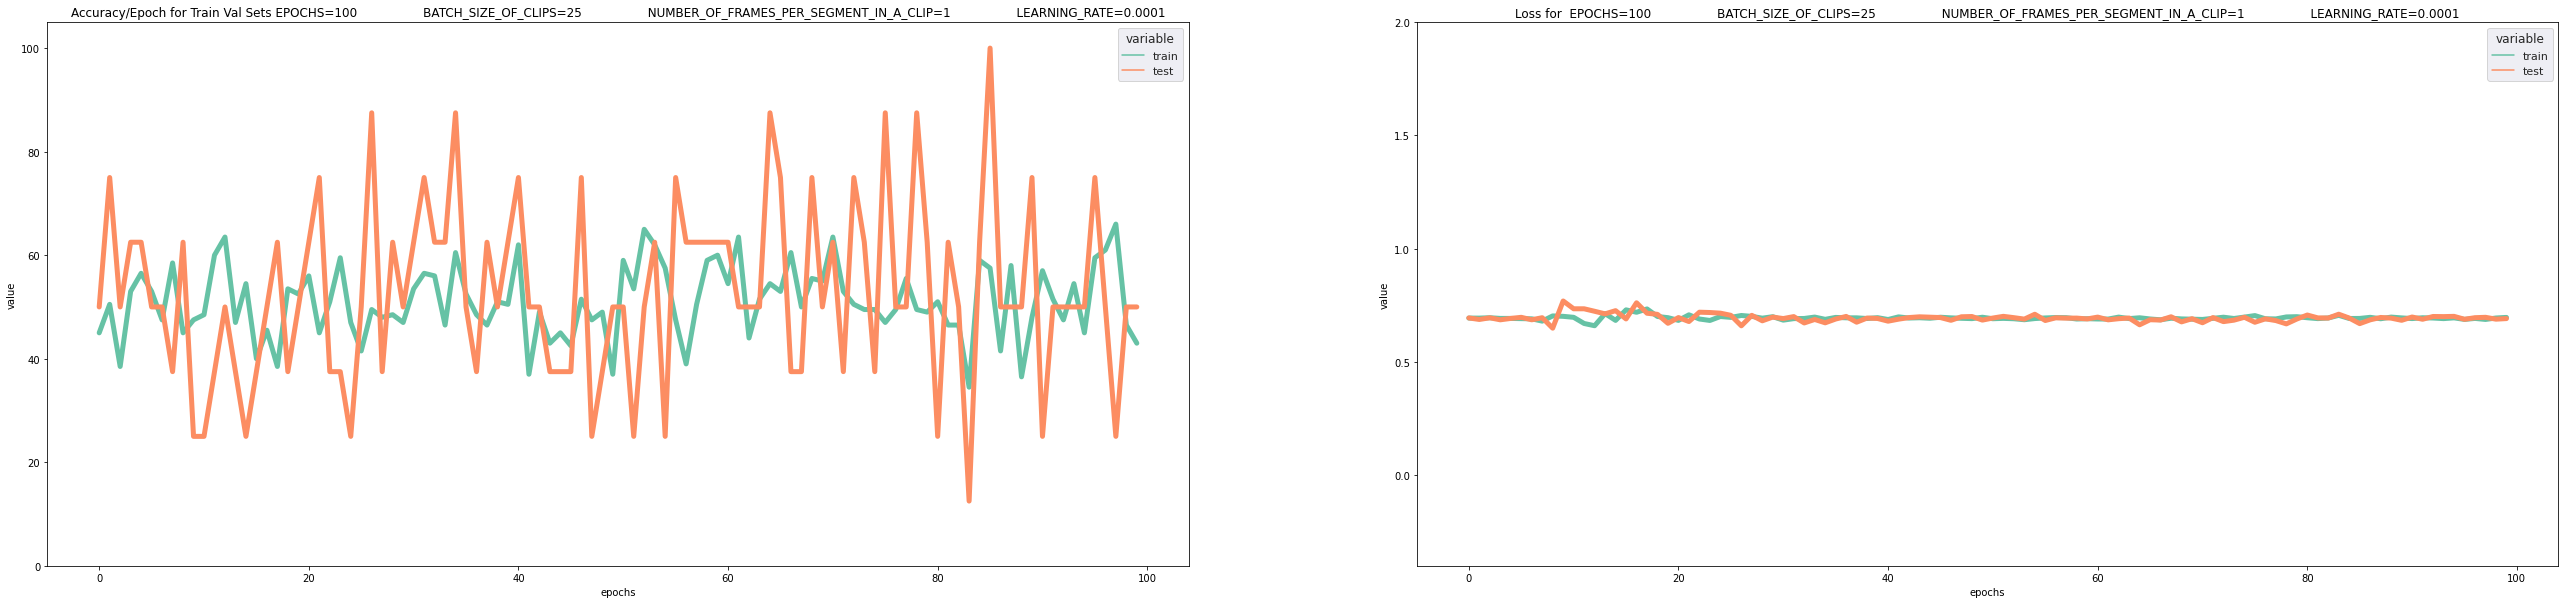

In [11]:
## Convert stats as dataframes
loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
## Concatenate dataframes and dictionaries
loss_df.insert(0, 'curve', 'Loss', True)
acc_df.insert(0, 'curve', 'Acc', True)
valuesall = [loss_df, acc_df]
values_all = pd.concat(valuesall)

all_stats = {
    'ACC': accuracy_stats,
    'LOS': loss_stats,
}


## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)


#################################
#### PLOTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,10))
sns.set(style="darkgrid")
sns.lineplot(
    data=acc_df, 
    x = "epochs", y="value", hue="variable",  ax=axes[0],    
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Accuracy/Epoch for Train Val Sets EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')

axes[0].set_ylim(0,105)

sns.set(style="darkgrid")
sns.lineplot(
    data=loss_df, 
    x = "epochs", y="value", hue="variable", ax=axes[1],
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Loss for  EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')
axes[1].set_ylim(-0.4, 2)



#### PREPARING AND SAVING PERFORMANCE CURVES
WIDTH = 3
PRECISION = 10
TYPE = "f"
STR_LR = f'{LEARNING_RATE:{WIDTH}.{PRECISION}{TYPE}}'
STR_LR = STR_LR.replace(".", "_", 1)

PARAMETERS_FILENAME = "TRAINset_clips_"+ \
                    str(len(train_dataset))+"TESTset_clips_"+ \
                    str(len(test_dataset))+"VALset_clips"+ \
                    str(len(val_dataset))+"___EPOCHS_"+str(f'{MAX_EPOCHS:{WIDTH}}') + \
                    "_BATCH_SIZE_OF_CLIPS_"+str(f'{BATCH_SIZE_OF_CLIPS:02}')+ \
                    "_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_"+ \
                    str(NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP)+"_LEARNING_RATE_"+ STR_LR + \
                    "_TRAINVERSION_"+TRAIN_VERSION

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TEMP_DICT_TRAINING_CURVES_FOR = "TEMP_DICT_TRAINING_CURVES_FOR____"
IMAGE_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+PARAMETERS_FILENAME
#print(IMAGE_FILE_NAME)
fig.savefig(IMAGE_FILE_NAME) 

## Saving training metrics in dictionaries at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
LOSS_ACC_DICTS_FILE_NAME = "TEMP_DICT_TRAINING_CURVES_FOR____"+"_LOSS_ACC_"+PARAMETERS_FILENAME+'.json'
#print(LOSS_ACC_DICTS_FILE_NAME)
#print(all_stats)

with open(LOSS_ACC_DICTS_FILE_NAME, 'w') as file:
   file.write(json.dumps(all_stats, indent=2))
    


## 11. Evaluate the model on test dataset

In [12]:
model.load_state_dict(torch.load(
    os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(val_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(DEVICE), sample_batched[1].to(DEVICE)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
print(f'==================================================')        
print(f'==================================================')        
print(get_class_distribution(val_dataset, label_id))
print(f'y_true_list{y_true_list}')
print(f'y_pred_list{y_pred_list}')



 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([14, 1, 1, 512, 512])
   y_train_batch.size(): torch.Size([14])
{'BKGR': 7, '4CV': 7}
y_true_list[1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
y_pred_list[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]


              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.67      0.57      0.62         7

    accuracy                           0.64        14
   macro avg       0.65      0.64      0.64        14
weighted avg       0.65      0.64      0.64        14

                    Precision    Recall  F1-score  Support
0                    0.625000  0.714286  0.666667      7.0
1                    0.666667  0.571429  0.615385      7.0
weighted avg/Total   0.645833  0.642857  0.641026      NaN
Avg/Total                 NaN       NaN       NaN     14.0
[[5 2]
 [3 4]]
Elapsed time for the notebook loop: 345.43051528930664 (s)


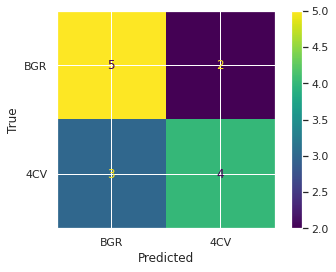

In [13]:
report = classification_report(y_true_list, y_pred_list)
print(report)
# report_support = precision_recall_fscore_support(y_true_list, y_pred_list)
# print(report_support)

def metrics_report_to_df(ytrue, ypred):
    classification_report_df = pd.DataFrame(data=list(precision_recall_fscore_support(y_true_list, y_pred_list)), \
                                         index=['Precision', 'Recall', 'F1-score', 'Support']).T    
    classification_report_df.loc['weighted avg/Total', :] = precision_recall_fscore_support(ytrue, ypred, average='weighted')
    classification_report_df.loc['Avg/Total', 'Support'] = classification_report_df['Support'].sum()
    return(classification_report_df)

classification_report_df = metrics_report_to_df(y_true_list, y_pred_list)
print(classification_report_df)

#################################
### PLOTTING CONFUSION MATRIX
cm=confusion_matrix(y_true_list, y_pred_list)
print(cm)
#cm=confusion_matrix(y_true_list, y_pred_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['BGR','4CV'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')


END_TIME_OF_THE_NOTEBOOK = time.time()
NOTEBOOK_ELAPSE_TIME = END_TIME_OF_THE_NOTEBOOK - START_TIME_OF_THE_NOTEBOOK
print(f'Elapsed time for the notebook loop: {NOTEBOOK_ELAPSE_TIME} (s)')



#### PREPARING AND SAVING TRAINING PERFORMANCE PARAMETERS
train_values = {} # instantiate an empty train_values dict 
train_values['elapsed_time_for_the_NOTEBOOK_in_secs'] = NOTEBOOK_ELAPSE_TIME
train_values['elapsed_time_for_the_training_loop_in_secs'] = elapsed_time
train_values['MAX_EPOCHS'] = MAX_EPOCHS
train_values['LEARNING_RATE'] = LEARNING_RATE
train_values['BATCH_SIZE_OF_CLIPS'] = BATCH_SIZE_OF_CLIPS
train_values['PRETRANSFORM_IM_SIZE'] = PRETRANSFORM_IM_SIZE
train_values['FRAMES_PER_CLIP'] = NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP
train_values['Train Dataset Size in Number of Frames'] = len(train_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Test Dataset Size in Number of Frames'] = len(test_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Validation Dataset Size in Number of Frames'] = len(val_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Current date and time'] = datetime.now().strftime('%dD-%mM-%yY_%HH-%MM-%SS')
train_values['Classification Report']=classification_report_df.head().to_dict()
train_values['Training version']= TRAIN_VERSION
# train_values['Optimizer']=pd.read_csv(io.StringIO(str(optimizer))).to_dict() #ERRORS
train_values['Optimizer']=str(optimizer)
train_values['Arquitecture']=(str(model)[:])#.head().to_dict()


## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TRAIN_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+"TRAINING_PARAMETERS"+PARAMETERS_FILENAME+".json"


with open(TRAIN_FILE_NAME, 'w') as file:
     file.write(json.dumps(train_values, indent=4))

        


## 12. [**!WARNING!**] Cleanup temporal data directory 
Remove directory if a temporary was used.

```
       Make sure you know which path you will remove as you do not like to remove important files.
       shutil.rmtree
```

In [14]:
temporal_files_path = config['temporal_data_path']

shutil.rmtree(temporal_files_path)
print(f' {temporal_files_path} is empty')

 /home/mx19/datasets/vital-us/echocardiography/temporal-files/ is empty
